In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------------
# Helper: k-means clustering
# -------------------------------
def kmeans(X, k, max_iters=100, tol=1e-4):
    """
    Simple k-means clustering.
    
    Parameters:
      X: numpy array of shape (n_samples, n_features)
      k: number of clusters
      max_iters: maximum number of iterations
      tol: tolerance for convergence
    Returns:
      centers: numpy array of shape (k, n_features)
      labels: cluster label for each data point
    """
    n_samples = X.shape[0]
    # Initialize: randomly choose k points as centers
    indices = np.random.choice(n_samples, k, replace=False)
    centers = X[indices]
    
    for it in range(max_iters):
        # Assignment step: compute distances and assign each point to nearest center
        distances = np.linalg.norm(X[:, np.newaxis, :] - centers[np.newaxis, :, :], axis=2)
        labels = np.argmin(distances, axis=1)
        
        new_centers = np.array([X[labels==j].mean(axis=0) if np.any(labels==j) else centers[j] 
                                for j in range(k)])
        # Check for convergence
        if np.linalg.norm(new_centers - centers) < tol:
            break
        centers = new_centers
    return centers, labels

# -------------------------------
# Helper: Gaussian RBF function
# -------------------------------
def gaussian_rbf(x, center, sigma):
    return np.exp(-np.linalg.norm(x - center)**2 / (2 * sigma**2))

# -------------------------------
# RBF Network Class
# -------------------------------
class RBFNetwork:
    def __init__(self, num_centers, sigma=None):
        """
        num_centers: number of RBF neurons (centers)
        sigma: spread parameter (if None, computed from centers)
        """
        self.num_centers = num_centers
        self.centers = None
        self.sigma = sigma  # if None, we will compute it after clustering
        self.weights = None  # weights for the linear output layer

    def _compute_design_matrix(self, X):
        """
        Computes the design (activation) matrix H for data X.
        H[i, j] = exp( -||X[i] - center_j||^2 / (2 * sigma^2) )
        """
        n_samples = X.shape[0]
        H = np.zeros((n_samples, self.num_centers))
        for i in range(n_samples):
            for j in range(self.num_centers):
                H[i, j] = gaussian_rbf(X[i], self.centers[j], self.sigma)
        return H

    def fit(self, X, y):
        """
        Train the RBF network.
        X: training data of shape (n_samples, n_features)
        y: target labels (assumed as integers starting from 0)
        """
        # 1. Select centers using k-means clustering:
        self.centers, _ = kmeans(X, self.num_centers)
        
        # 2. Compute sigma if not provided.
        # Here we use the average distance between centers.
        if self.sigma is None:
            dists = []
            for i in range(self.num_centers):
                for j in range(i+1, self.num_centers):
                    dists.append(np.linalg.norm(self.centers[i] - self.centers[j]))
            self.sigma = np.mean(dists)
            if self.sigma == 0:
                self.sigma = 1.0
        
        # 3. Create the design matrix H for training data:
        H = self._compute_design_matrix(X)
        
        # 4. One-hot encode y for multi-class classification:
        classes = np.unique(y)
        self.classes_ = classes
        T = np.zeros((y.shape[0], len(classes)))
        for i, label in enumerate(y):
            T[i, np.where(classes == label)[0][0]] = 1

        # 5. Solve for weights using least squares (pseudo-inverse):
        H_pinv = np.linalg.pinv(H)
        self.weights = H_pinv.dot(T)

    def predict(self, X):
        """
        Predict class labels for input data X.
        """
        H = self._compute_design_matrix(X)
        outputs = H.dot(self.weights)
        # Predicted label is the index of maximum output; map back to original class labels.
        preds = np.argmax(outputs, axis=1)
        return self.classes_[preds]


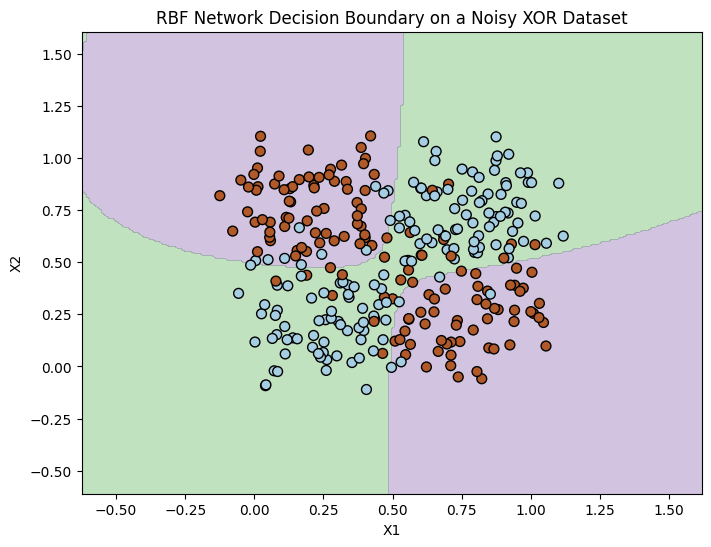

In [4]:
# Create a toy XOR dataset
np.random.seed(42)
# Four clusters (2 classes) in 2D:
X_toy = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])
y_toy = np.array([0, 1, 1, 0])  # XOR labeling

# To make it a bit more challenging, add some noise and additional samples:
def generate_noisy_xor(n_samples=200, noise=0.1):
    X = np.random.rand(n_samples, 2)
    y = np.array([0 if (x[0] < 0.5 and x[1] < 0.5) or (x[0] >= 0.5 and x[1] >= 0.5) else 1
                  for x in X])
    X += noise * np.random.randn(n_samples, 2)
    return X, y

X_toy, y_toy = generate_noisy_xor(n_samples=300, noise=0.08)

# Train an RBF Network on the toy dataset:
num_centers = 10
rbf_net = RBFNetwork(num_centers=num_centers)
rbf_net.fit(X_toy, y_toy)

# Create a mesh grid for visualization:
x_min, x_max = X_toy[:,0].min()-0.5, X_toy[:,0].max()+0.5
y_min, y_max = X_toy[:,1].min()-0.5, X_toy[:,1].max()+0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid_points = np.c_[xx.ravel(), yy.ravel()]

Z = rbf_net.predict(grid_points)
Z = Z.reshape(xx.shape)

# Plot the decision boundary and training points
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, levels=np.linspace(0, 1, 3), cmap=plt.cm.Paired)
plt.scatter(X_toy[:,0], X_toy[:,1], c=y_toy, s=50, cmap=plt.cm.Paired, edgecolors='k')
plt.title("RBF Network Decision Boundary on a Noisy XOR Dataset")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()


In [5]:
# -------------------------------
# Load and preprocess the Wine dataset
# -------------------------------
# The wine dataset URL from UCI: 
wine_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
# Column names: first column is the class label, the next 13 are features.
columns = ['Class', 'Alcohol', 'Malic_acid', 'Ash', 'Alcalinity_of_ash', 'Magnesium',
           'Total_phenols', 'Flavanoids', 'Nonflavanoid_phenols', 'Proanthocyanins',
           'Color_intensity', 'Hue', 'OD280/OD315_of_diluted_wines', 'Proline']
wine_df = pd.read_csv(wine_url, header=None, names=columns)

# Separate features and target; note that the class labels are 1, 2, 3.
X_wine = wine_df.iloc[:, 1:].values  # shape (n_samples, 13)
y_wine = wine_df['Class'].values - 1  # subtract 1 to get labels 0,1,2

# Normalize features (min-max scaling):
X_min = X_wine.min(axis=0)
X_max = X_wine.max(axis=0)
X_wine = (X_wine - X_min) / (X_max - X_min)

# Split into training and test sets (e.g., 70%-30% split)
np.random.seed(1)
indices = np.random.permutation(len(X_wine))
split = int(0.7 * len(X_wine))
train_idx, test_idx = indices[:split], indices[split:]
X_train, X_test = X_wine[train_idx], X_wine[test_idx]
y_train, y_test = y_wine[train_idx], y_wine[test_idx]

# -------------------------------
# Train the RBF network on the Wine dataset
# -------------------------------
num_centers = 20  # You may experiment with this hyperparameter.
rbf_wine = RBFNetwork(num_centers=num_centers)
rbf_wine.fit(X_train, y_train)

# Predict on test data:
y_pred = rbf_wine.predict(X_test)

# Compute accuracy:
accuracy = np.mean(y_pred == y_test)
print("RBF Network Test Accuracy on Wine dataset: {:.2f}%".format(accuracy * 100))


RBF Network Test Accuracy on Wine dataset: 98.15%


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

# Convert training and test data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

# Define a simple MLP network (one hidden layer)
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        return self.net(x)

input_dim = X_train.shape[1]   # 13 features
hidden_dim = 20                # you can experiment with this number
output_dim = len(np.unique(y_train))  # 3 classes

mlp = SimpleMLP(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.01)

# Training loop:
num_epochs = 200
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = mlp(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate on test set:
with torch.no_grad():
    test_outputs = mlp(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    mlp_accuracy = (predicted == y_test_tensor).float().mean()
    print("MLP Test Accuracy on Wine dataset: {:.2f}%".format(mlp_accuracy.item() * 100))


Epoch [50/200], Loss: 0.1754
Epoch [100/200], Loss: 0.0399
Epoch [150/200], Loss: 0.0191
Epoch [200/200], Loss: 0.0113
MLP Test Accuracy on Wine dataset: 96.30%
